In [39]:
import torch
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

### Loading the Data

In [42]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

### Model

In [29]:
# your favourite MLP model

def create_model(show_summary = False):

    seq = [torch.nn.Flatten()]
    seq.append(torch.nn.Dropout(p=0.1))
    seq.append(torch.nn.Linear(in_features=28*28, out_features=200))
    seq.append(torch.nn.ReLU())
    seq.append(torch.nn.Dropout(p=0.2))
    seq.append(torch.nn.Linear(in_features=200, out_features=10))

    _model = torch.nn.Sequential(*seq)

    if show_summary:
        print(summary(_model, (1,28,28)))

    return _model

In [30]:
check_model = create_model(True)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Flatten: 1-1                           [1, 784]                  --
├─Dropout: 1-2                           [1, 784]                  --
├─Linear: 1-3                            [1, 200]                  157,000
├─ReLU: 1-4                              [1, 200]                  --
├─Dropout: 1-5                           [1, 200]                  --
├─Linear: 1-6                            [1, 10]                   2,010
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
Total mult-adds (M): 0.16
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.64
Estimated Total Size (MB): 0.64


### Train-Eval over a given number of epochs for a given train/validation loader (4+1 fold)

In [52]:
def test_eval(model, test_loader):

    cost_ce = torch.nn.CrossEntropyLoss()

    test_set_size = len(test_loader.dataset)
    test_num_batches = len(test_loader)

    print("test_set_size:", test_set_size)
    print("test_num_batches:", test_num_batches)

    cost_test, acc_test = 0, 0
    with torch.no_grad():
        for valid_batch_idx, (X, Y) in enumerate(test_loader):
            pred = model(X)
            cost_test += cost_ce(pred, Y).item()
            acc_test += (Y == pred.argmax(dim=1)).type(torch.float).sum().item()

    print("Test-Acc:", acc_test)

    cost_test = cost_test / test_num_batches
    acc_test = acc_test / test_set_size

    print("acc_test:", acc_test)

    return cost_test, acc_test

In [37]:
def train_eval(nepochs, model, lr, training_loader, validation_loader, cost_fn):

    cost_hist_train = []
    acc_hist_train = []

    cost_hist_valid = []
    acc_hist_valid = []

    # Define cost function and optimizer
    cost_ce = cost_fn
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    print(f'Start with -> lr: {lr}, num_epoch: {nepochs}')

    for epoch in range(nepochs):

        # get for both train and test set the length and batch size
        train_set_size = len(training_loader.dataset)
        train_num_batches = len(training_loader)

        cost_train, acc_train = 0, 0

        for train_batch_idx, (X, Y) in enumerate(training_loader):

            # make prediction and calculate loss
            y_pred = model(X)
            loss = cost_ce(y_pred, Y)

            cost_train += loss.item()
            acc_train += (Y == y_pred.argmax(dim=1)).type(torch.float).sum().item()

            # reset gradients, so that they aren't cumulated
            optimizer.zero_grad()

            # calculate gradients
            loss.backward()

            # apply gradients and update parameters
            optimizer.step()

        # calculate average training cost and accuracy per epoch
        cost_train = cost_train / train_num_batches
        acc_train = acc_train / train_set_size

        # evaluate validation cost and accuracy
        cost_valid, acc_valid = test_eval(model, validation_loader)

        # store result
        cost_hist_train.append(cost_train)
        cost_hist_valid.append(cost_valid)
        acc_hist_train.append(acc_train)
        acc_hist_valid.append(acc_valid)

        print("Epoch %i: cost_train: %f, acc_train: %f, cost_valid: %f, acc_valid: %f"%(epoch, cost_train, acc_train, cost_valid, acc_valid))


    return cost_hist_train, cost_hist_valid, acc_hist_train, acc_hist_valid

### Split Training Data into folds

Prepare specific loaders for the 4 training folds and the 1 validation fold

Suggestions:
* Use sklearns KFold functionality for spliiting into folds.
* Use pytorchs subsamplers (torch.utils.data.SubsetRandomSampler) to construct training and validation loaders

In [ ]:
# Configuration options, todo hyperparameter tuning
nfolds = 5
nepochs = 20
lr = 0.3
batchsize = 64

cost_fn = torch.nn.CrossEntropyLoss()
results = {}

In [53]:
# Training

kfold = KFold(n_splits=nfolds, shuffle=True)



for fold, (train_idx, valid_idx) in enumerate(kfold.split(training_data)):

    print(f'FOLD {fold}')
    print('--------------------------------')

    _model = create_model()

    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

    train_loader = DataLoader(dataset=training_data, shuffle=False, batch_size=batchsize, sampler=train_sampler)
    validation_loader = DataLoader(dataset=training_data, shuffle=False, batch_size=batchsize, sampler=val_sampler)

    results[fold] = train_eval(nepochs, _model, lr, train_loader, validation_loader, cost_fn)

FOLD 0
--------------------------------
Start with -> lr: 0.3, num_epoch: 20
test_set_size: 60000
test_num_batches: 188
Test-Acc: 9104.0
acc_test: 0.15173333333333333
Epoch 0: cost_train: 0.632538, acc_train: 0.613300, cost_valid: 0.723543, acc_valid: 0.151733
test_set_size: 60000
test_num_batches: 188
Test-Acc: 10060.0
acc_test: 0.16766666666666666
Epoch 1: cost_train: 0.462258, acc_train: 0.663367, cost_valid: 0.456791, acc_valid: 0.167667
test_set_size: 60000
test_num_batches: 188
Test-Acc: 10019.0
acc_test: 0.16698333333333334
Epoch 2: cost_train: 0.422448, acc_train: 0.674667, cost_valid: 0.449731, acc_valid: 0.166983
test_set_size: 60000
test_num_batches: 188
Test-Acc: 10181.0
acc_test: 0.16968333333333332
Epoch 3: cost_train: 0.399064, acc_train: 0.681967, cost_valid: 0.412133, acc_valid: 0.169683
test_set_size: 60000
test_num_batches: 188
Test-Acc: 10274.0
acc_test: 0.17123333333333332
Epoch 4: cost_train: 0.382837, acc_train: 0.686467, cost_valid: 0.395674, acc_valid: 0.171233

KeyboardInterrupt: 

In [21]:
for fold, (train_ids, valid_ids) in enumerate(kfold.split(training_data)):

    print(f'FOLD {fold}')
    print('--------------------------------')

    ....
    
    
    results[fold] = train_eval(nepochs, model, lr, trainloader, validloader, cost_fn) 

FOLD 0
--------------------------------
Epoch 0: 0.009533, 0.816479, 0.005067, 0.908250
Epoch 1: 0.004786, 0.911417, 0.004595, 0.913250
Epoch 2: 0.004079, 0.924083, 0.003734, 0.931750
Epoch 3: 0.003527, 0.934562, 0.003279, 0.940417
Epoch 4: 0.003100, 0.942771, 0.002905, 0.947750
Epoch 5: 0.002739, 0.949458, 0.002679, 0.949167
Epoch 6: 0.002446, 0.953958, 0.002566, 0.951500
Epoch 7: 0.002213, 0.959521, 0.002299, 0.956417
Epoch 8: 0.002010, 0.963104, 0.002167, 0.959917
Epoch 9: 0.001843, 0.965812, 0.002029, 0.962417
Epoch 10: 0.001693, 0.968854, 0.001872, 0.964167
Epoch 11: 0.001558, 0.971187, 0.001840, 0.966333
Epoch 12: 0.001443, 0.973583, 0.001840, 0.963917
Epoch 13: 0.001345, 0.976000, 0.001692, 0.968833
Epoch 14: 0.001253, 0.977563, 0.001608, 0.969500
Epoch 15: 0.001176, 0.978958, 0.001563, 0.970917
Epoch 16: 0.001100, 0.980313, 0.001515, 0.970750
Epoch 17: 0.001035, 0.982000, 0.001499, 0.971000
Epoch 18: 0.000970, 0.983042, 0.001415, 0.972167
Epoch 19: 0.000916, 0.984021, 0.001406,

### Prepare output plots

/var/folders/58/stlxrq7s6756j83tj45vg2480000gn/T/ipykernel_78602/612322057.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(results[fold][3], "ro", marker="+", color=colors[fold])
/var/folders/58/stlxrq7s6756j83tj45vg2480000gn/T/ipykernel_78602/612322057.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(results[fold][3], "ro", marker="+", color=colors[fold])


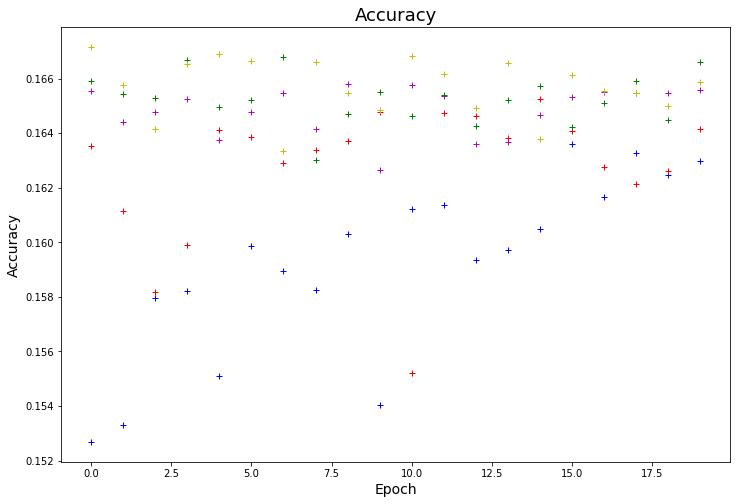

Text(0.5, 1.0, 'Accuracy')

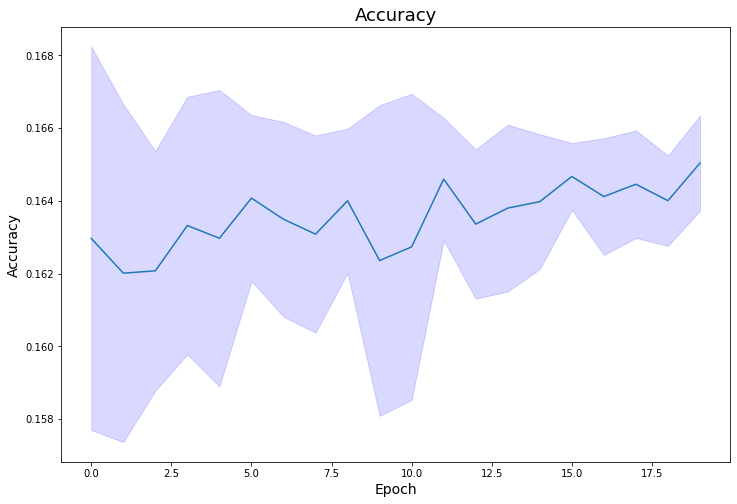

In [50]:
plt.figure(1, figsize=(12,8))

colors = ["b","r","m","g","y"]
colors_test = ["b-","r-","m-","g-","y-"]

for fold in range(len(results)):
    plt.plot(results[fold][3], "ro", marker="+", color=colors[fold])

plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy", fontsize=18)
plt.show()



plt.figure(1, figsize=(12,8))
scores = np.array([])
scores_std = np.array([])
for epoch in range(nepochs):

    _values = []
    for fold in range(len(results)):
        _values.append(results[fold][3][epoch])

    # calculate score and standard deviation
    scores = np.append(scores, np.mean(_values))
    scores_std = np.append(scores_std, np.std(_values))

plt.plot(scores)
plt.fill_between(range(0, len(scores)), scores + scores_std, scores - scores_std, alpha=0.15, color='blue')

plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy", fontsize=18)



/var/folders/58/stlxrq7s6756j83tj45vg2480000gn/T/ipykernel_78602/691777365.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(results[fold][2], "ro", marker="+", color=colors[fold])
/var/folders/58/stlxrq7s6756j83tj45vg2480000gn/T/ipykernel_78602/691777365.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(results[fold][2], "ro", marker="+", color=colors[fold])


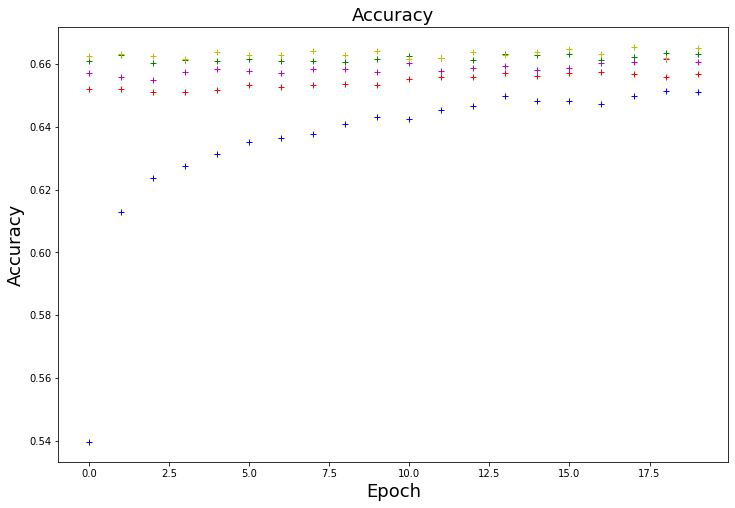

Text(0.5, 1.0, 'Accuracy')

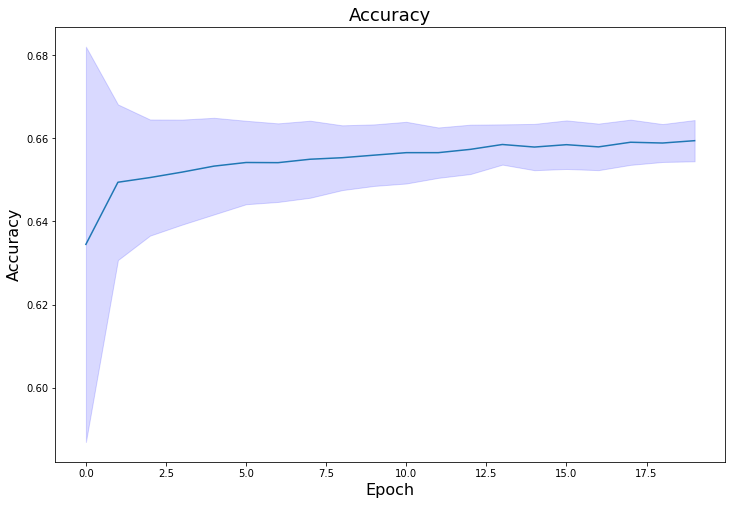

In [46]:
plt.figure(1, figsize=(12,8))

colors = ["b","r","m","g","y"]
colors_test = ["b-","r-","m-","g-","y-"]

for fold in range(len(results)):
    plt.plot(results[fold][2], "ro", marker="+", color=colors[fold])

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.title("Accuracy", fontsize=18)
plt.show()



plt.figure(1, figsize=(12,8))
scores = np.array([])
scores_std = np.array([])
for epoch in range(nepochs):

    _values = []
    for fold in range(len(results)):
        _values.append(results[fold][2][epoch])

    # calculate score and standard deviation
    scores = np.append(scores, np.mean(_values))
    scores_std = np.append(scores_std, np.std(_values))

plt.plot(scores)
plt.fill_between(range(0, len(scores)), scores + scores_std, scores - scores_std, alpha=0.15, color='blue')

plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.title("Accuracy", fontsize=18)